# Graded assignment 1 - text classification using Genetic Algorithms
## By Abdullah Karagøz

In this assignmetn we'll make a binary text classifier using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. This task consists of several steps:

1. Preprocessing of the text
2. Genetich Algorithm
3. Validation



## 1. Preprocessing

### 1.1 Uploading data

In [2]:
## Upload the text
import numpy as np
import pandas as pd
import nltk
import string
import re
import math
import random
from scipy import special
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates all in arrays
# Here we save the labels as one hot encoded arrays so it's easier to make
# calculations in the classifier easier.
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

### 1.2 Splitting data

In [4]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()

train_set['review'] = reviews_train_pos + reviews_train_neg
train_set['rate'] = rates_train_pos + rates_train_neg
train_set['label'] = labels_train_pos + labels_train_neg

negs_cut = int(len(labels_test_neg)/2)
poss_cut = int(len(labels_test_pos)/2)

test_set['review'] = reviews_test_pos[:poss_cut] + reviews_test_neg[:negs_cut]
test_set['rate'] = rates_test_pos[:poss_cut] + rates_test_neg[:negs_cut]
test_set['label'] = labels_test_pos[:poss_cut] + labels_test_neg[:negs_cut]

valid_set['review'] = reviews_test_pos[poss_cut:] + reviews_test_neg[negs_cut:]
valid_set['rate'] = rates_test_pos[poss_cut:] + rates_test_neg[negs_cut:]
valid_set['label'] = labels_test_pos[poss_cut:] + labels_test_neg[negs_cut:]

### 1.3 Data exploration

In [5]:
test_set

,review,rate,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
12495,Killjoy 2 is the same as killjoy 1. Bad acting...,1,0
12496,I really don't know why I agreed to watch this...,1,0
12497,Cops Logan Alexander and Debbie Rochon escort ...,2,0
12498,"Chuck Norris stars as Danny, a cop who took do...",2,0


In [6]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("\nMost common 20 counted by word count total: ", cnt.most_common(20))

# print("Least common 20 counted by appearance in nr of reviews: ", cnt2.most_common()[:-20])
# print("\nLeast common 20 counted by word count total: ", cnt.most_common()[:-20])



Most common 20 counted by appearance in nr of reviews:  [('the', 24666), ('a', 24047), ('and', 23964), ('of', 23675), ('to', 23405), ('is', 22260), ('in', 21644), ('this', 20697), ('that', 19539), ('it', 19041), ('I', 17968), ('for', 17356), ('with', 17062), ('but', 16164), ('was', 15992), ('The', 15610), ('as', 15376), ('on', 14946), ('/><br', 14665), ('have', 14011)]

Most common 20 counted by word count total:  [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568), ('is', 103229), ('in', 85580), ('I', 65973), ('that', 64560), ('this', 57199), ('it', 54439), ('/><br', 50935), ('was', 46698), ('as', 42510), ('with', 41721), ('for', 41070), ('but', 33790), ('The', 33762), ('on', 30767), ('movie', 30506)]


Text(0, 0.5, '% of documents')

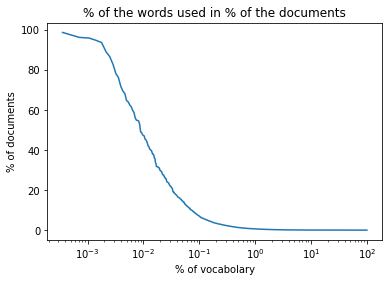

In [7]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = 25000

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

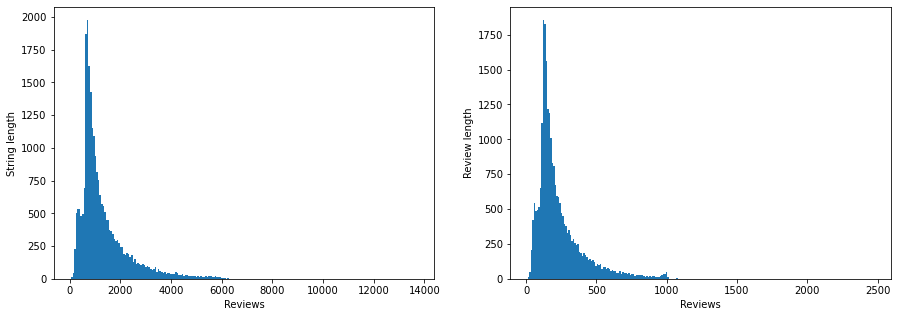

In [8]:
# Length distribution of the reviews
train_set['rev_lens_raw'] = train_set['review'].str.len()
train_set['rev_lens_words'] = train_set['review'].str.split().apply(len)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(train_set['rev_lens_raw'], bins='auto')
ax[0].set_xlabel("Reviews")
ax[0].set_ylabel("String length")
ax[1].hist(train_set['rev_lens_words'], bins='auto')
ax[1].set_xlabel("Reviews")
ax[1].set_ylabel("Review length")

plt.show()

In [9]:
train_set.nsmallest(10, 'rev_lens_words')['review'].values

array(['This movie is terrible but it has some good effects.',
       "I wouldn't rent this one even on dollar rental night.",
       "You'd better choose Paul Verhoeven's even if you have watched it.",
       'Adrian Pasdar is excellent is this film. He makes a fascinating woman.',
       'Ming The Merciless does a little Bardwork and a movie most foul!',
       'Long, boring, blasphemous. Never have I been so glad to see ending credits roll.',
       'Comment this movie is impossible. Is terrible, very improbable, bad interpretation e direction. Not look!!!!!',
       'This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.',
       'no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!',
       "I don't know why I like this movie so well, but I never get tired of watching it."],
      dtype=object)

In [10]:
#train_set.nlargest(1, 'rev_lens_words')['review'].values


### 1.4 Preprocessing and vectorization

#### TextPreprocessor class

In [11]:
# I think to put this into own .PY file and import from there
class TextPreprocessor():
    def __init__(self):
        import nltk
        import re
        import string
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        from nltk.stem.wordnet import WordNetLemmatizer 
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }
        
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile('<.*?>')

    def lower_case(self, text):
        return str.lower(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        return " ".join([word for word in text.split() if word not in self.stop_words])
    
    def remove_words(self, text, freq_words):
        return " ".join([word for word in text.split() if word not in freq_words])
    
    def remove_emoji(self, text):
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        import re
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return " ".join(tokens)
    
    def expand_contractions(self, text):
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" wasn't ", " was not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"in'", "ing", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_numbers(self, text):
        text = re.sub(r'[0-9]', '', text)
        return text
    
    def remove_html_tags(self, text):
        return self.html_pattern.sub(r'', text)
    
    def remove_urls(self, text):
        return self.url_pattern.sub(r'', text)
    
    def process_text_vectorized(self, text):
        text = self.lower_case(text)
        text = self.remove_html_tags(text)
        text = self.remove_numbers(text)
        text = self.remove_urls(text)
        text = self.expand_contractions(text)
        text = self.remove_emoji(text)
        text = self.remove_punctuation(text)
        text = self.lemmatization(text)
        text = self.remove_stopwords(text)
        return text
    
    def preprocess_2(self, corpus, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        
        vecpreprop = np.vectorize(self.process_text_vectorized)
        
        arr1 = vecpreprop(corpus)
        
        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in corpus:
            # Counting the words
            for word in text.split():
                cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
        freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        rem_freq_words = np.vectorize(self.remove_words)
        arr2 = rem_freq_words(arr1, freq_words)

        # Removing rarest words
        rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
        
        rem_rare_words = np.vectorize(self.remove_words)
        arr3 = rem_rare_words(arr2, rare_words)

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(corpus) * max_df
        curb_min_amount = len(corpus) * min_df

        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        print(len(cnt2))
        print(len(curb_words))
        rem_curb_words = np.vectorize(self.remove_words)
        arr4 = rem_curb_words(arr3, curb_words)
        
        return arr4

        
        
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_html_tags(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_numbers(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))

        df['processed'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_stopwords(text))


        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in df['processed'].values:
            # Counting the words
#             for word in text.split():
#                 cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
#         freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, freq_words))

#         # Removing rarest words
#         rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rare_words))

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df
        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, curb_words))

        return df


#### TF IDF Vectorizer class

In [12]:
# TF-IDF VECTORIZER CLASS
import math
from collections import Counter
import numpy as np
from nltk import FreqDist

class TfIdfVectorizer:
    def __init__(self, df):
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        self._idfs = idfs
    
    @property
    def vocab(self):
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        # Prepare the vocab
        self.vocab = set(" ".join(df['processed'].values).split())
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["processed"].values:
            for word in set(text.split()):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = 0 if c == 0 else math.log(size / c)
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        freq_dist = FreqDist(text)
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        vectors = np.array(df['processed'].apply(lambda text: self.tf_idf_vectorize(text)).values.tolist())
        return vectors
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        vector = np.array(df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels)).values.tolist())
        return vector


    



In [13]:
#Using the preprocessor
preprocessor = TextPreprocessor()
train_set_processed = preprocessor.preprocess_imdb_reviews(train_set, 0.85, 0.0005)
test_set_processed = preprocessor.preprocess_imdb_reviews(test_set, 0.85, 0.0005)
valid_set_processed = preprocessor.preprocess_imdb_reviews(valid_set, 0.85, 0.0005)

train_set_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,rate,label,rev_lens_raw,rev_lens_words,processed
0,Bromwell High is a cartoon comedy. It ran at t...,9,1,806,140,high cartoon comedy run time program school li...
1,Homelessness (or Houselessness as George Carli...,8,1,2366,428,george state issue year never plan help street...
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1,841,147,brilliant overact ann warren best dramatic lad...
3,This is easily the most underrated film inn th...,7,1,663,124,easily underrate film inn brook cannon sure fl...
4,This is not the typical Mel Brooks film. It wa...,8,1,647,120,typical mel brook film much le slapstick movie...
...,...,...,...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",4,0,1567,280,towards end movie felt technical felt like cla...
24996,This is the kind of movie that my enemies cont...,3,0,859,152,kind movie enemy content watch time bloody tru...
24997,I saw 'Descent' last night at the Stockholm Fi...,3,0,1688,289,saw last night film festival one huge disappoi...
24998,Some films that you pick up for a pound turn o...,1,0,1277,232,film pick pound turn rather good rd century fi...


In [14]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab


# Vectorizing train set and test set
X_train = vectorizer.tf_idf_vectorize_all(train_set_processed)

X_test = vectorizer.tf_idf_vectorize_all(test_set_processed)

X_valid = vectorizer.tf_idf_vectorize_all(valid_set_processed)

Y_train = train_set_processed['label'].to_numpy()

Y_test = test_set_processed['label'].to_numpy()

Y_valid = valid_set_processed['label'].to_numpy()

In [25]:
for x in X_valid:
    print(x)
    break

[0. 0. 0. ... 0. 0. 0.]


## 2. Set up genetic algorithm


### 2.1 Classifier
There are a lot of classifiers. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

In [107]:
class Classifier:
    def __init__(self, idfs, vocab):
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
        self.np_predictor = np.vectorize(lambda vec: self.predict(vec))

    # Initializing weights
    def init_weights(self, hidden_nodes):
        self.ws_1 = np.random.rand(len(vocab), hidden_nodes) - 0.5
        self.ws_2 = np.random.rand(hidden_nodes, 2) - 0.5
        self.hn_1 = hidden_nodes
        
    def set_weights(self, ws_1, ws_2):
        self.ws_1 = ws_1
        self.ws_2 = ws_2
        
    def relu(self, x):
        return (x > 0) * x
    
    def relu_grad(self, x):
        return x > 0
    
    def sigmoid(self, x):
        from scipy import special
        return special.expit(x)
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    
    def softmax(self, x):
        import numpy as np
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        
    def train_with_SGD(self, epochs, lr, x, y, hidden_nodes):
        self.init_weights(hidden_nodes)
        error_list = list()
        mse_list = list()
        
        for n in range(epochs):
            for i in range(x.shape[0]):
                l_in = x[i:i+1]
                l_o, l_2, l_1, s_1 = self.predict(l_in, True)
                
                delta_2 = l_2 - y[i:i+1]
                delta_1 = delta_2.dot(self.ws_2.T) * self.relu_grad(l_1)
                
                self.ws_2 -= lr * (l_1.T.reshape(self.hn_1,1).dot(delta_2))
                self.ws_1 -= lr * (l_in.T.reshape(x.shape[1],1).dot(delta_1))
                
                error = delta_2**2
                    
                error_list.append(error[0][0])
            
            mse_list.append(sum(error_list) / x.shape[0])
            error_list = list()
        
        cel, output, acc = self.predict_whole_set(x, y)
        
        return mse_list, cel, output, acc
                

    def cross_entropy(self, p, y):
        import numpy as np
        return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
    
    def predict(self, x, get_all=False):
        #forward pass/prediction
        sum_1 = x.dot(self.ws_1)
        layer_1 = self.relu(sum_1)
        layer_2 = layer_1.dot(self.ws_2)
        layer_out = self.softmax(layer_2)
        if get_all:
            return layer_out, layer_2, layer_1, sum_1
        else:
            return layer_out
    
    def get_accuracy(self, y, p):
        acc = np.sum((y == np.argmax(p, axis=1))) / len(y)
        return acc
    
    
    
    def predict_whole_set(self, x, y, get_acc = True):
        output = np.apply_along_axis(self.predict, 1, x)
        cel = self.cross_entropy(output, y)
        if get_acc:
            acc = self.get_accuracy(y, output)
        
        
        if get_acc:
            acc = self.get_accuracy(y, output)
            return cel, output, acc
        else:
            return cel, output
    

        

In [303]:
# Initialize classifier
classifier = Classifier(idfs, vocab)
classifier.init_weights(8)
cel, p, acc = classifier.predict_whole_set(X_valid, Y_valid)
print(cel)
print(acc)
print(sum(np.argmax(p, axis=1)))
p

10.369438482630311
0.50008
12499


<ipython-input-107-257fd46a281c>:67: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
<ipython-input-107-257fd46a281c>:67: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2


array([[2.61716359e-21, 1.00000000e+00],
       [1.15144101e-57, 1.00000000e+00],
       [9.63411517e-69, 1.00000000e+00],
       ...,
       [4.52801953e-44, 1.00000000e+00],
       [6.60748294e-21, 1.00000000e+00],
       [5.53990491e-54, 1.00000000e+00]])

In [304]:
# Training with SGD
mse, cel, output, acc = classifier.train_with_SGD(15, 0.1, X_valid, Y_valid, 8)

In [305]:
print(mse[0], mse[-1])
print(cel)
print(acc)
print(sum(np.argmax(output, axis=1)))
p

25250181728937.277 0.5
0.17328679513998632
0.5
0


array([[2.61716359e-21, 1.00000000e+00],
       [1.15144101e-57, 1.00000000e+00],
       [9.63411517e-69, 1.00000000e+00],
       ...,
       [4.52801953e-44, 1.00000000e+00],
       [6.60748294e-21, 1.00000000e+00],
       [5.53990491e-54, 1.00000000e+00]])

In [119]:
%%time
# Test run classifier
classifier.init_weights(8)
cel_pre, output1, acc_pre = classifier.predict_whole_set(X_valid, Y_valid)
print(cel_pre, acc_pre)



inf 0.5
Wall time: 403 ms


<ipython-input-107-257fd46a281c>:67: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
<ipython-input-107-257fd46a281c>:67: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
C:\Users\abdka\anaconda3\envs\01basics\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


### 2.2 Chromosome
It's just some weights that'll be used for classification

In [1294]:
class Chromosome:
    # x_pos and y_pos are the features of our chromosome
    def __init__(self, ws_1, ws_2):
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
    
    # Getters and setters
    @property
    def ws_1(self):
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        self._ws_1 = value
    
    @property
    def ws_2(self):
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        self._ws_2 = value
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        self._fitness = value
    
    def assign_fitness(self, classifier, x, y):
        import math
        classifier.set_weights(self.ws_1, self.ws_2)
        loss, _, acc = classifier.predict_whole_set(x, y, True)
        self.fitness = acc #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        r = 0
        
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r) 
        
        offspring = Chromosome(ws_1, ws_2)
        return offspring

    # mutate the individual
    def mutate(self):
        np.random.shuffle(self.ws_1)
        self.ws_1 = self.ws_1 + np.random.uniform(-1, 1, size=self.ws_1.shape)
        np.random.shuffle(self.ws_2)
        self.ws_2 = self.ws_2 + np.random.uniform(-1, 1, size=self.ws_2.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

In [1295]:
class GAEngine:
    def __init__(self):
        self._population = []
        self._generations = 0

    def make_initial_population(self, population_size):       
        for i in range(population_size):
            ws_1, ws_2 = self.init_weights()
            self.population.append(Chromosome(ws_1, ws_2))

        
    @property
    def generations(self):
        return self._generations
    
    @generations.setter
    def generations(self, g):
        self._generations = g
    
    @property
    def population(self):
        return self._population
    
    @population.setter
    def population(self, p):
        self._population = p
    
    
    # Initializing weights
    def init_weights(self):
        hidden_nodes = 8
        ws_1 = np.random.rand(len(vocab), hidden_nodes) - 0.5
        ws_2 = np.random.rand(hidden_nodes, 2) - 0.5
        return ws_1, ws_2
    

    # selection code goes here...
    def do_crossover(self, no_of_offspring):
        import random
        population_size = len(self.population)
        # Here we combine elitism selection with roulette wheel
        # We carry ca 20 % of the most fit over to the next generation.
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        # Get the top ca 20 % fittest.
        rate_to_keep = 0.2
        keep_nr = int(population_size * rate_to_keep)
        self.population = sorted(self.population, key=lambda x: x.fitness)
        new_generation = self.population[-keep_nr:]
        
        # new_generation = list()

        # Then we make offsprings based on random choices with weights.
        # We raise the exponent fitness to 2 to make the differences more
        # Since we are using "roulette wheel" in selection, we want to increase the chance of
        # the most fit to be selected.
        fitness_values = [x.fitness**2 for x in self.population]
        for i in range(no_of_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        self.population = new_generation
        return
    
    
    # fitness calculation goes here...
    def assign_fitness(self, classifier, x, y):
        # Fitness is 987 substracted by distance to closest food
        # We want the chromosomes close to some food to survive, not close to all foods on average.
        for ch in self.population:
            ch.assign_fitness(classifier, x, y)
        return
    
    def get_population(self):
        return self.population
    
    def get_best_chromosome(self):
        ch = max(self.population, key=lambda x: x.fitness)
        return ch
    
    def training_routine(self, init_population, nr_of_generations, 
                        no_of_mutation, rate_of_crossover, x, y, classifier):
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        
        cels = list()


        for i in range(self.generations):
            self.assign_fitness(classifier, x, y)
            cels.append(self.get_best_chromosome().fitness)
            # ca 60 % of population to do crossover
            no_of_crossover = int(rate_of_crossover * len(self.population))
            self.do_crossover(no_of_crossover)


            # High number of mutations for more variations
            for i in range(no_of_mutation):
                index = random.randint(0, len(self.population)-1)
                self.population[index].mutate()
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness(classifier, x, y)
        cels.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), cels


In [1306]:
%%time
# Here I run the GA engine
ga = GAEngine()
gens = 10
ch, cels = ga.training_routine(10, gens, 2, 0.8, X_test, Y_test, classifier)
cels


<ipython-input-1219-22596ed1aaf7>:33: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
<ipython-input-1219-22596ed1aaf7>:33: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
C:\Users\abdka\anaconda3\envs\01basics\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Wall time: 1min


[0.51416,
 0.53072,
 0.53072,
 0.53952,
 0.53952,
 0.53952,
 0.53952,
 0.53952,
 0.53952,
 0.53896,
 0.50616]

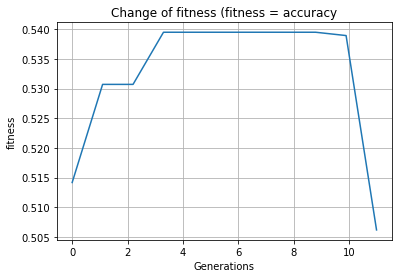

In [1307]:
# Plotting increase of fitness in training
x = np.linspace(0, gens+1, gens+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy")

plt.grid()
plt.show()


## 3. Validation

In [1310]:
classifier.set_weights(ch.ws_1, ch.ws_2)
cel_post, output_post, acc_post = classifier.predict_whole_set(X_valid, Y_valid)

<ipython-input-1219-22596ed1aaf7>:33: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2
<ipython-input-1219-22596ed1aaf7>:33: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() / 2


In [1311]:
print("Accuracy before training: ", acc_pre)
print("Accuracy after training: ", acc_post)
print("CEL before training", cel_pre)
print("CEL after training", cel_post)

Accuracy before training:  0.5
Accuracy after training:  0.50848
CEL before training 6.597198386572049
CEL after training inf


In [103]:
arr1 = [1,2,3]
arr2 = [4,5]
arr3 = [7,8, 9,10]

nparr3 = np.array([arr1, arr2, arr3])
nparr = np.array([[1,2,3],[3,4,5],[4,5,6]])
nparr2 = np.array([[1, 3],[3, 4],[3,4],[3,2],[2,1],[9,3]])

np.argmax(nparr2, axis=1)
nparr2

<ipython-input-103-b4c45037dd8a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nparr3 = np.array([arr1, arr2, arr3])


array([[1, 3],
       [3, 4],
       [3, 4],
       [3, 2],
       [2, 1],
       [9, 3]])

In [ ]:
np.random.rand(3, 2)

In [ ]:
starr = np.array(["thIs is Good", "this is BAD", "this is NOT so good"])

class test:
    def __init__(self):
        return
    
    def func(self, x, y):
        x = x + y
        return str.lower(x)
    

t = test()

vecfunc = np.vectorize(t.func)

vecfunc(starr, "aaa")

In [ ]:
np.char.split(starr)

In [ ]:
yy = [0, 1, 1]
zz = [[0.5, 0.9],[0.5, 0.9], [0.5, 0.9]]
np.eye(2)[yy]
#-np.nan_to_num(yy*np.log(zz))

In [ ]:
-np.log(0.9)

In [ ]:
x = "aaa"
y = x + "bb"
y

In [ ]:
%%time
" ".join(train_set['reviews'].values)